# Assignment 1:
Loading the data:

In [47]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from numpy import transpose as trans
from scipy.linalg import block_diag

In [48]:
raceData = pd.read_csv("AllData.csv")

# Information about data set:
drivers = np.unique(np.array(raceData["driverId"]))
numDrivers = len(drivers)

## 1.1 Plotting

(0.0, 58.0)

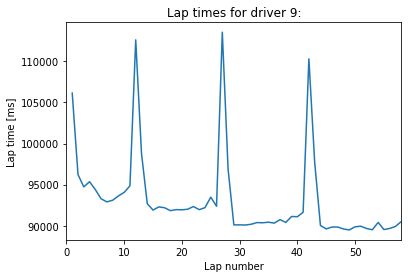

In [49]:
# Plotting data for given driver:
driverId = 9

raceDataDriver = raceData[raceData["driverId"] == driverId]

# Plot
plt.plot(raceDataDriver["lap_number"], raceDataDriver["lap_time"])
plt.title(f"Lap times for driver {driverId}:")
plt.xlabel("Lap number")
plt.ylabel("Lap time [ms]")
plt.xlim([0, len(raceDataDriver)])


(0.0, 58.0)

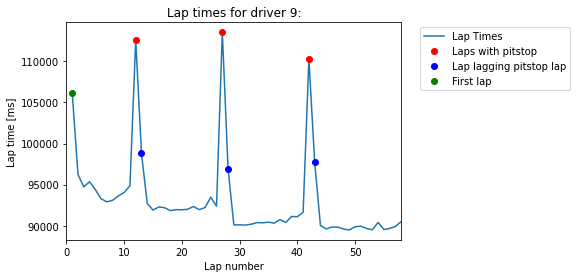

In [50]:
# Extract lap number and lap times of laps with pit stop and laps lagging that lap:
lapIsPitStop = np.array(raceDataDriver["pitstop"])
lapNumbers = np.array(raceDataDriver["lap_number"])
lapTimes = np.array(raceDataDriver["lap_time"])

lapsWithPitStopTime = []
lapsWithPitStop = []

lapsLaggingPitStopTime = []
lapsLaggingPitStop = []


# Extract the laps with pit stops
for lap in lapNumbers:
    if lapIsPitStop[lap-1]:
        lapsWithPitStop.append(lap)
        lapsWithPitStopTime.append(lapTimes[lap-1])

        lapsLaggingPitStop.append(lap+1)
        lapsLaggingPitStopTime.append(lapTimes[lap])


# Plot lap times with the pitstop marked:
plt.plot(lapNumbers, lapTimes)
plt.plot(lapsWithPitStop, lapsWithPitStopTime, 'ro')
plt.plot(lapsLaggingPitStop, lapsLaggingPitStopTime, 'bo')
plt.plot(lapNumbers[0], lapTimes[0], 'go')
plt.title(f"Lap times for driver {driverId}:")
plt.xlabel("Lap number")
plt.ylabel("Lap time [ms]")
plt.legend(["Lap Times", "Laps with pitstop", "Lap lagging pitstop lap", "First lap"], bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlim([0, len(raceDataDriver)])

## 1.2 OLS

Construct the X matrix and train the model:

In [51]:
# Parameters:
numTrain = 51
numTest = max(raceData["lap_number"]) - numTrain

# Useful information about the training set:
lapIsPitstopTrain = trans(np.array([raceData[raceData["lap_number"] <= numTrain]["pitstop"]]).astype(int))
lapIsLaggingPitstopTrain = trans(np.array([raceData[raceData["lap_number"] <= numTrain]["pitstop_lagged"]]))
lapIsFirstLapTrain = np.array(raceData[raceData["lap_number"] <= numTrain]["lap_number"] == 1).astype(int)
lapIsFirstLapTrain = trans(np.array([lapIsFirstLapTrain]))

numTrainingLaps =  len(raceData[raceData["lap_number"] <= numTrain])
numPitstopTrain = np.count_nonzero(lapIsPitstopTrain)
numLaggedPitstopTrain = np.count_nonzero(lapIsLaggingPitstopTrain)
numFirstLapTrain = np.count_nonzero(lapIsFirstLapTrain)
numNormalLaps = numTrainingLaps - numPitstopTrain - numLaggedPitstopTrain - numFirstLapTrain

drivers = np.unique(np.array(raceData["driverId"]))
numDrivers = len(drivers)

# Create the X matrix for training the model:
XTrain = np.array(pd.get_dummies(raceData[raceData["lap_number"] <= numTrain]["driverId"]))
XTrain = np.c_[XTrain, np.array(raceData[raceData["lap_number"] <= numTrain]["lap_number"])]
XTrain = np.c_[XTrain, np.array(raceData[raceData["lap_number"] <= numTrain]["pitstop"]).astype(int)]
XTrain = np.c_[XTrain, np.array(raceData[raceData["lap_number"] <= numTrain]["pitstop_lagged"])]
XTrain = np.c_[XTrain, (np.array(raceData[raceData["lap_number"] <= numTrain]["lap_number"]) == 1).astype(int)]

# Y vector for training:
YTrain = trans(np.array([raceData[raceData["lap_number"] <= 51]["lap_time"]]))

# Training the model:
parametersOLS = np.linalg.inv((trans(XTrain) @ XTrain)) @ trans(XTrain) @ YTrain

# Extracting the parameters:
alphaOLS = parametersOLS[:21]
betaOLS = parametersOLS[21]
deltaOLS = parametersOLS[22] # Parameter for pitstop laps
muOLS = parametersOLS[23] # Parameter for lap lagging pitstop
phiOLS = parametersOLS[24] # Parameter for first lap


Now I will make predictions on the test laps:

 alpha: 93527.72 
 beta: -76.77 
 delta: 22000.77 
 mu: 7475.0 
 phi: 16310.25


<ipython-input-87-f1d0df88ac47>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]
<ipython-input-87-f1d0df88ac47>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trainingDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] <= numTrain]


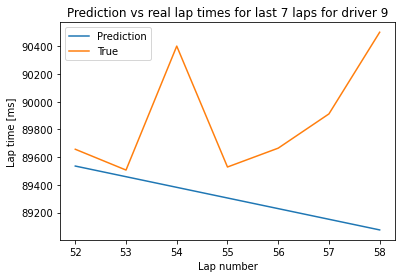

In [87]:
# Id for driver:
driverId = 9

# Extract the race data for the driver:
testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]
trainingDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] <= numTrain]

# Get the XTest and YTest:
lapNumbersDriverTest = np.array(testDataDriver["lap_number"])
lapTimesDriverTest = np.array(testDataDriver["lap_time"])

lapIsPitstopDriver = np.array(testDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(testDataDriver["pitstop_lagged"])
firstLap = np.array(testDataDriver["lap_number"] == 1).astype(int)

# Make the prediction:
predictionDriverOLS = alphaOLS[driverId - 1] + betaOLS * lapNumbersDriverTest + deltaOLS * lapIsPitstopDriver + muOLS * lapsLaggingPitStopDriver + phiOLS * firstLap

# Print the parameters:
print(f" alpha: {round(alphaOLS[driverId - 1][0], 2)} \n beta: {round(betaOLS[0], 2)} \n delta: {round(deltaOLS[0], 2)} \n\
 mu: {round(muOLS[0],2)} \n phi: {round(phiOLS[0], 2)}")

# Plot predictions and true value
plt.plot(lapNumbersDriverTest, predictionDriverOLS)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId}")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])


Now I calculate the sigma in order to provide a measure of uncertainty on the prediction.

#### Make predictions for all drivers on all data

In [90]:
# Make predictions on the training data for all drivers:
predictionAllDriversOLS = XTrain @ parametersOLS

N = len(YTrain) # Number of samples
p = len(parametersOLS) # Number of parameters

# Calculate the variance sigma2 and std sigma:
sigma2OLS = (trans(YTrain - predictionAllDriversOLS) @ (YTrain - predictionAllDriversOLS)) /(N - p)
sigmaOLS = np.sqrt(sigma2OLS)
print(f"Sigma: {round(sigmaOLS[0][0], 2)}")

Sigma: 2398.56


In [91]:
# Variance of parameters:
varParameters = sigma2OLS * np.linalg.inv((trans(XTrain) @ XTrain))
for std in np.sqrt(np.diag(varParameters)):
    print(f"Std: {round(std, 2)}")

Std: 368.76
Std: 368.76
Std: 369.56
Std: 368.76
Std: 369.56
Std: 369.56
Std: 517.53
Std: 368.76
Std: 369.56
Std: 368.76
Std: 368.76
Std: 368.76
Std: 368.76
Std: 368.28
Std: 555.46
Std: 802.83
Std: 368.76
Std: 368.76
Std: 375.94
Std: 368.76
Std: 555.46
Std: 5.69
Std: 384.4
Std: 384.42
Std: 546.53


Predicted lap time: 89535.86002507313 Prediction interval: +-6755.35056335988 

Predicted lap time: 89459.09339227427 Prediction interval: +-6855.801402392419 

Predicted lap time: 89382.32675947543 Prediction interval: +-6958.544793645221 

Predicted lap time: 89305.56012667659 Prediction interval: +-7063.54960636084 

Predicted lap time: 89228.79349387773 Prediction interval: +-7170.784373928441 

Predicted lap time: 89152.02686107889 Prediction interval: +-7280.217415160422 

Predicted lap time: 89075.26022828004 Prediction interval: +-7391.816944748909 



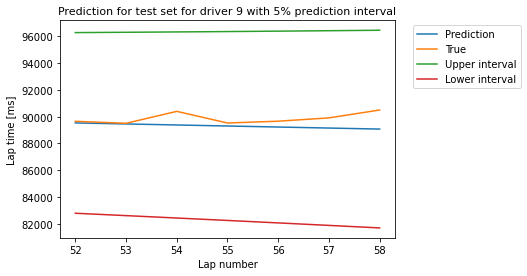

In [92]:
from scipy.stats import t

# Extract XTrain and YTrain for making prediction intervals on the test data:
lapNumbersTraining = trans(np.array([trainingDataDriver["lap_number"]]))
lapNumbersTest = trans(np.array([testDataDriver["lap_number"]]))

# Calculate prediction interval for the test data:
predictionIntervalDriverOLS = []
predictedlaps = lapNumbersTraining
for lap in lapNumbersTest:
    predictedlaps = np.append(predictedlaps, lap)
    predictionIntervalDriverOLS = np.append(predictionIntervalDriverOLS, \
        t.ppf(1-0.025, N - p) * sigmaOLS * np.sqrt(1 + trans(predictedlaps) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ predictedlaps))

# Plot predictions, true value and prediction interval:
plt.plot(lapNumbersDriverTest, predictionDriverOLS)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.plot(lapNumbersDriverTest, predictionDriverOLS + predictionIntervalDriverOLS)
plt.plot(lapNumbersDriverTest, predictionDriverOLS - predictionIntervalDriverOLS)
plt.title(f"Prediction for test set for driver {driverId} with 5% prediction interval", size= 11)
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"], bbox_to_anchor=(1.04,1), loc="upper left")

for lap in lapNumbersTest:
    print(f"Predicted lap time: {predictionDriverOLS[lap - numTrain - 1][0]} Prediction interval: +-{predictionIntervalDriverOLS[lap - numTrain - 1][0]} \n" )

Make prediction intervals on both training and test data for a driver:

#### Make the prediction for a driver on all the data:

In [93]:
# Id of the driver
driverId = 9

# Get the reace data for the driver
raceDataDriver = raceData[raceData["driverId"] == driverId]

lapNumbersDriver = trans(np.array(raceDataDriver["lap_number"]))
lapTimesDriver = trans(np.array(raceDataDriver["lap_time"]))

lapIsPitstopDriver = np.array(raceDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(raceDataDriver["pitstop_lagged"])
firstLapDriver = np.array(raceDataDriver["lap_number"] == 1).astype(int)

predictionAllDataOLS = alphaOLS[driverId - 1] + betaOLS * lapNumbersDriver + deltaOLS * lapIsPitstopDriver \
    + muOLS * lapsLaggingPitStopDriver + phiOLS * firstLapDriver

### Calculate the prediction interval for the driver:

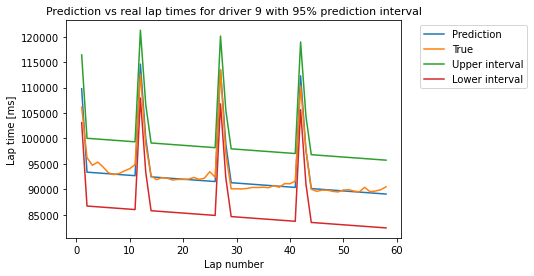

In [94]:
from scipy.stats import norm

lapNumbersDriver = trans(np.array([raceDataDriver["lap_number"]]))
lapTimesDriver = trans(np.array([raceDataDriver["lap_time"]]))

# Make confidence intervals:
confidenceIntervalOLS = t.ppf(1-0.025, N-p) * sigmaOLS \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

# Plot predictions and true value
plt.plot(lapNumbersDriver, predictionAllDataOLS)
plt.plot(lapNumbersDriver, lapTimesDriver)
plt.plot(lapNumbersDriver, predictionAllDataOLS + confidenceIntervalOLS[0])
plt.plot(lapNumbersDriver, predictionAllDataOLS - confidenceIntervalOLS[0])
plt.title(f"Prediction vs real lap times for driver {driverId} with 95% prediction interval", size= 11)
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"], bbox_to_anchor=(1.04,1), loc="upper left")

## 1.3 WLS

The covariance matrix are the same for each driver. Thus we have to calculate the covariance matrix for each driver and make the bigger covariance matrix for all drivers.

In [96]:
# Parameter to create covariance matrix:
rho = 0.5

# Create a array with all the covariance matrices for all the drivers:
covMatricesGamma = []
gammaMatrices = []

for driverId in drivers:
    raceDataDriver = raceData[raceData["driverId"] == driverId]
    numLaps = len(raceDataDriver[raceDataDriver["lap_number"] <= 51])

    covMatrix = np.zeros([numLaps, numLaps])
    
    for n in range(numLaps):
        covCol = np.ones(numLaps)
        gammaCol = np.ones(numLaps)
        for i in range(-n, numLaps - n):
            covCol[i+n] = rho**abs(i)
        covMatrix[n] = covCol
    
    covMatricesGamma.append(covMatrix)

# Create the big covariance matrix by placing the prior calculated covarince matrices along the diagonal:
covMatrixAllDrivers = block_diag(*covMatricesGamma)

Now that I hava calculated the covarince matrix I will use WLS to find new parameters:

In [99]:
# Make the model:
parametersWLS = np.linalg.inv((trans(XTrain) @ np.linalg.inv(covMatrixAllDrivers) @ XTrain)) @ trans(XTrain) @ np.linalg.inv(covMatrixAllDrivers) @ YTrain

alphaWLS = parametersWLS[:21]
betaWLS = parametersWLS[21]
deltaWLS = parametersWLS[22] # Parameter for pitstop laps
muWLS = parametersWLS[23] # Parameter for lap lagging pitstop
phiWLS = parametersWLS[24] # Parameter for first lap

# Print the parameters:
print(f" alpha: {round(alphaWLS[driverId - 1][0], 2)} \n beta: {round(betaWLS[0], 2)} \n delta: {round(deltaWLS[0], 2)} \n\
 mu: {round(muWLS[0],2)} \n phi: {round(phiWLS[0], 2)}")

 alpha: 102183.53 
 beta: -75.73 
 delta: 21638.08 
 mu: 7384.06 
 phi: 15654.99


<ipython-input-100-d95e7c2bf5cc>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]
<ipython-input-100-d95e7c2bf5cc>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trainingDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] <= numTrain]


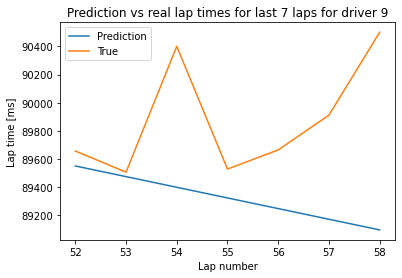

In [100]:
# Id for driver:
driverId = 9

# Extract the race data for the driver:
testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]
trainingDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] <= numTrain]

# Get the XTest and YTest:
lapNumbersDriverTest = np.array(testDataDriver["lap_number"])
lapTimesDriverTest = np.array(testDataDriver["lap_time"])

lapIsPitstopDriver = np.array(testDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(testDataDriver["pitstop_lagged"])
firstLap = np.array(testDataDriver["lap_number"] == 1).astype(int)

# Make the prediction:
predictionDriverWLS = alphaWLS[driverId - 1] + betaWLS * lapNumbersDriverTest + deltaWLS * lapIsPitstopDriver + muWLS * lapsLaggingPitStopDriver + phiWLS * firstLap

# Plot predictions and true value
plt.plot(lapNumbersDriverTest, predictionDriverWLS)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId}")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

### Same as in 1.2:

In [101]:
# Make predictions on the training data for all drivers:
predictionAllDriversWLS = XTrain @ parametersWLS

N = len(YTrain) # Number of samples
p = len(parametersWLS) # Number of parameters

# Calculate the variance sigma2 and std sigma:
sigma2WLS = (trans(YTrain - predictionAllDriversWLS) @ np.linalg.inv(covMatrixAllDrivers) @ (YTrain - predictionAllDriversWLS)) /(N - p)
sigmaWLS = np.sqrt(sigma2WLS)
print(f"Sigma: {round(sigmaWLS[0][0], 2)}")

Sigma: 2707.12


In [102]:
# Variance of parameters:
varParameters = sigma2WLS * np.linalg.inv((trans(XTrain) @ XTrain))
for std in np.sqrt(np.diag(varParameters)):
    print(f"Std: {round(std, 2)}")

Std: 416.2
Std: 416.2
Std: 417.1
Std: 416.2
Std: 417.1
Std: 417.1
Std: 584.1
Std: 416.2
Std: 417.1
Std: 416.2
Std: 416.2
Std: 416.2
Std: 416.2
Std: 415.66
Std: 626.91
Std: 906.11
Std: 416.2
Std: 416.2
Std: 424.31
Std: 416.2
Std: 626.91
Std: 6.42
Std: 433.85
Std: 433.88
Std: 616.83


Predicted lap time: 89550.98 Prediction interval: +-7624.39 

Predicted lap time: 89475.25 Prediction interval: +-7737.76 

Predicted lap time: 89399.51 Prediction interval: +-7853.72 

Predicted lap time: 89323.78 Prediction interval: +-7972.24 

Predicted lap time: 89248.04 Prediction interval: +-8093.27 

Predicted lap time: 89172.31 Prediction interval: +-8216.78 

Predicted lap time: 89096.58 Prediction interval: +-8342.73 



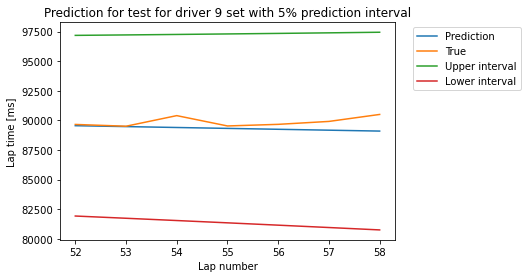

In [103]:
# Extract XTrain and YTrain for making prediction intervals on the test data:
lapNumbersTraining = trans(np.array([trainingDataDriver["lap_number"]]))
lapNumbersTest = trans(np.array([testDataDriver["lap_number"]]))

# Calculate prediction interval for the test data:
predictionIntervalDriverWLS = []
predictedlaps = lapNumbersTraining
for lap in lapNumbersTest:
    predictedlaps = np.append(predictedlaps, lap)
    predictionIntervalDriverWLS = np.append(predictionIntervalDriverWLS, \
        t.ppf(1-0.025, N - p) * sigmaWLS * np.sqrt(1 + trans(predictedlaps) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ predictedlaps))

# Plot predictions, true value and prediction interval:
plt.plot(lapNumbersDriverTest, predictionDriverWLS)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.plot(lapNumbersDriverTest, predictionDriverWLS + predictionIntervalDriverWLS)
plt.plot(lapNumbersDriverTest, predictionDriverWLS - predictionIntervalDriverWLS)
plt.title(f"Prediction for test for driver {driverId} set with 5% prediction interval")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"], bbox_to_anchor=(1.04,1), loc="upper left")

for lap in lapNumbersTest:
    print(f"Predicted lap time: {round(predictionDriverWLS[lap - numTrain - 1][0],2)} Prediction interval: +-{round(predictionIntervalDriverWLS[lap - numTrain - 1][0], 2)} \n" )

In [104]:
# Id of the driver
driverId = 9

# Get the reace data for the driver
raceDataDriver = raceData[raceData["driverId"] == driverId]

lapNumbersDriver = trans(np.array(raceDataDriver["lap_number"]))
lapTimesDriver = trans(np.array(raceDataDriver["lap_time"]))

lapIsPitstopDriver = np.array(raceDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(raceDataDriver["pitstop_lagged"])
firstLapDriver = np.array(raceDataDriver["lap_number"] == 1).astype(int)

predictionAllDataWLS = alphaWLS[driverId - 1] + betaWLS * lapNumbersDriver + deltaWLS * lapIsPitstopDriver \
    + muWLS * lapsLaggingPitStopDriver + phiWLS * firstLapDriver

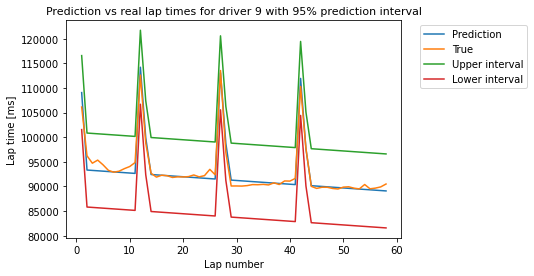

In [105]:
lapNumbersDriver = trans(np.array([raceDataDriver["lap_number"]]))
lapTimesDriver = trans(np.array([raceDataDriver["lap_time"]]))

# Make confidence intervals:
confidenceIntervalWLS = t.ppf(1-0.025, N-p) * sigmaWLS \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

# Plot predictions and true value
plt.plot(lapNumbersDriver, predictionAllDataWLS)
plt.plot(lapNumbersDriver, lapTimesDriver)
plt.plot(lapNumbersDriver, predictionAllDataWLS + confidenceIntervalWLS[0])
plt.plot(lapNumbersDriver, predictionAllDataWLS - confidenceIntervalWLS[0])
plt.title(f"Prediction vs real lap times for driver {driverId} with 95% prediction interval", size= 11)
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"], bbox_to_anchor=(1.04,1), loc="upper left")


Adjust the covarance matrix by multiplying some of its values:

In [106]:
# Parameter to create covariance matrix:
rho = 0.5

gammaPitstop = 1.5
gammaPistopLagged = 1.5
gammaFirstLap = 1.5

# Create a array with all the covariance matrices for all the drivers:
covMatricesGamma = []
gammaMatrices = []

for driverId in drivers:
    raceDataDriver = raceData[raceData["driverId"] == driverId]
    numLaps = len(raceDataDriver[raceDataDriver["lap_number"] <= 51])

    lapIsPitStop = np.array(raceDataDriver["pitstop"])
    lapLaggingPitStop = np.array(raceDataDriver["pitstop_lagged"]).astype(bool)
    isFirstLap = (np.array(raceDataDriver["lap_number"]) == 1)

    covMatrixGamma = np.zeros([numLaps, numLaps])
    gammaMatrix = np.ones([numLaps, numLaps])
    
    for n in range(numLaps):
        covCol = np.ones(numLaps)
        gammaCol = np.ones(numLaps)
        for i in range(-n, numLaps - n):
            covCol[i+n] = rho**abs(i)
        covMatrixGamma[n] = covCol

        if lapIsPitStop[n]:
            gammaMatrix[n] = gammaCol * gammaPitstop

        if lapLaggingPitStop[n]:
            gammaMatrix[n] = gammaCol * gammaPistopLagged

        if isFirstLap[n]:
            gammaMatrix[n] = gammaCol * gammaFirstLap
    
    covMatricesGamma.append(covMatrixGamma)
    gammaMatrices.append(gammaMatrix)

# Create the big covariance matrix by placing the prior calculated covarince matrices along the diagonal:
gammaMatrixAllDrivers = block_diag(*gammaMatrices)

covMatrixAllDriversGamma = block_diag(*covMatricesGamma) * gammaMatrixAllDrivers * trans(gammaMatrixAllDrivers)

### Train the model with the new covariancve matrix:

In [108]:
# Make the model:
parametersWLSGamma = np.linalg.inv((trans(XTrain) @ np.linalg.inv(covMatrixAllDriversGamma) @ XTrain)) @ trans(XTrain) @ np.linalg.inv(covMatrixAllDriversGamma) @ YTrain

alphaWLSGamma = parametersWLSGamma[:21]
betaWLSGamma = parametersWLSGamma[21]
deltaWLSGamma = parametersWLSGamma[22] # Parameter for pitstop laps
muWLSGamma = parametersWLSGamma[23] # Parameter for lap lagging pitstop
phiWLSGamma = parametersWLSGamma[24] # Parameter for first lap

# Print the parameters:
print(f" alpha: {round(alphaWLSGamma[driverId - 1][0], 2)} \n beta: {round(betaWLSGamma[0], 2)} \n delta: {round(deltaWLSGamma[0], 2)} \n\
 mu: {round(muWLSGamma[0],2)} \n phi: {round(phiWLSGamma[0], 2)}")

 alpha: 99061.19 
 beta: -82.77 
 delta: 21487.09 
 mu: 7364.41 
 phi: 15349.59


<ipython-input-109-90935245efdd>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]


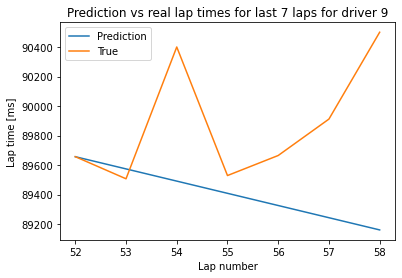

In [109]:
# Id for driver:
driverId = 9

# Extract the race data for the driver:
testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]

# Get the XTest and YTest:
lapNumbersDriverTest = np.array(testDataDriver["lap_number"])
lapTimesDriverTest = np.array(testDataDriver["lap_time"])

lapIsPitstopDriver = np.array(testDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(testDataDriver["pitstop_lagged"])
firstLap = np.array(testDataDriver["lap_number"] == 1).astype(int)

# Make the prediction:
predictionDriverWLSGamma = alphaWLSGamma[driverId - 1] + betaWLSGamma * lapNumbersDriverTest + deltaWLSGamma * lapIsPitstopDriver \
    + muWLSGamma * lapsLaggingPitStopDriver + phiWLSGamma * firstLap

# Plot predictions and true value
plt.plot(lapNumbersDriverTest, predictionDriverWLSGamma)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId}")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])

In [110]:
# Make predictions on the training data for all drivers:
predictionAllDriversWLSGamma = XTrain @ parametersWLSGamma

N = len(YTrain) # Number of samples
p = len(parametersWLSGamma) # Number of parameters

# Calculate the variance sigma2 and std sigma:
sigma2WLSGamma = (trans(YTrain - predictionAllDriversWLSGamma) @ np.linalg.inv(covMatrixAllDriversGamma) @ (YTrain - predictionAllDriversWLSGamma)) /(N - p)
sigmaWLSGamma = np.sqrt(sigma2WLSGamma)
print(f"Sigma: {round(sigmaWLSGamma[0][0],2)}")

Sigma: 1980.58


In [111]:
# Variance of parameters:
varParameters = sigma2WLSGamma * np.linalg.inv((trans(XTrain) @ XTrain))
for std in np.sqrt(np.diag(varParameters)):
    print(f"Std: {round(std, 2)}")

Std: 304.5
Std: 304.5
Std: 305.16
Std: 304.5
Std: 305.16
Std: 305.16
Std: 427.34
Std: 304.5
Std: 305.16
Std: 304.5
Std: 304.5
Std: 304.5
Std: 304.5
Std: 304.11
Std: 458.66
Std: 662.92
Std: 304.5
Std: 304.5
Std: 310.43
Std: 304.5
Std: 458.66
Std: 4.7
Std: 317.41
Std: 317.43
Std: 451.29


Predicted lap time: 89656.79 Prediction interval: +-5578.15 

Predicted lap time: 89574.02 Prediction interval: +-5661.09 

Predicted lap time: 89491.26 Prediction interval: +-5745.93 

Predicted lap time: 89408.49 Prediction interval: +-5832.64 

Predicted lap time: 89325.73 Prediction interval: +-5921.18 

Predicted lap time: 89242.96 Prediction interval: +-6011.55 

Predicted lap time: 89160.2 Prediction interval: +-6103.7 



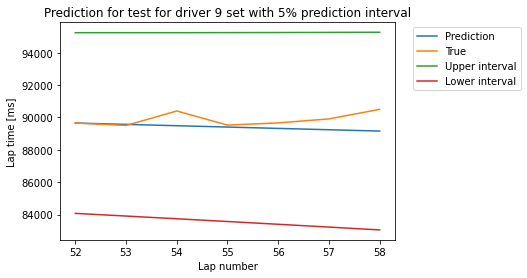

In [112]:
# Extract XTrain and YTrain for making prediction intervals on the test data:
lapNumbersTraining = trans(np.array([trainingDataDriver["lap_number"]]))
lapNumbersTest = trans(np.array([testDataDriver["lap_number"]]))

# Calculate prediction interval for the test data:
predictionIntervalDriverWLSGamma = []
predictedlaps = lapNumbersTraining
for lap in lapNumbersTest:
    predictedlaps = np.append(predictedlaps, lap)
    predictionIntervalDriverWLSGamma = np.append(predictionIntervalDriverWLSGamma, \
        t.ppf(1-0.025, N - p) * sigmaWLSGamma * np.sqrt(1 + trans(predictedlaps) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ predictedlaps))

# Plot predictions, true value and prediction interval:
plt.plot(lapNumbersDriverTest, predictionDriverWLSGamma)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.plot(lapNumbersDriverTest, predictionDriverWLSGamma + predictionIntervalDriverWLSGamma)
plt.plot(lapNumbersDriverTest, predictionDriverWLSGamma - predictionIntervalDriverWLSGamma)
plt.title(f"Prediction for test for driver {driverId} set with 5% prediction interval")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"], bbox_to_anchor=(1.04,1), loc="upper left")

for lap in lapNumbersTest:
    print(f"Predicted lap time: {round(predictionDriverWLSGamma[lap - numTrain - 1][0], 2)} Prediction interval: +-{round(predictionIntervalDriverWLSGamma[lap - numTrain - 1][0], 2)} \n" )

In [113]:
# Id of the driver
driverId = 9

# Get the reace data for the driver
raceDataDriver = raceData[raceData["driverId"] == driverId]

lapNumbersDriver = trans(np.array(raceDataDriver["lap_number"]))
lapTimesDriver = trans(np.array(raceDataDriver["lap_time"]))

lapIsPitstopDriver = np.array(raceDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(raceDataDriver["pitstop_lagged"])
firstLapDriver = np.array(raceDataDriver["lap_number"] == 1).astype(int)

predictionAllDataWLSGamma = alphaWLSGamma[driverId - 1] + betaWLSGamma * lapNumbersDriver + deltaWLSGamma * lapIsPitstopDriver \
    + muWLSGamma * lapsLaggingPitStopDriver + phiWLSGamma * firstLapDriver

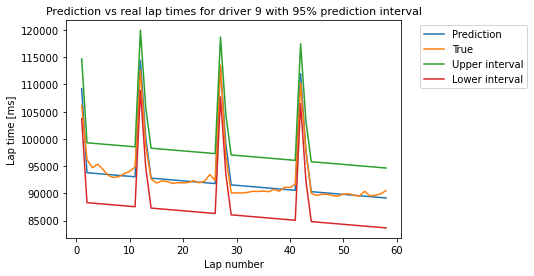

In [114]:
lapNumbersDriver = trans(np.array([raceDataDriver["lap_number"]]))
lapTimesDriver = trans(np.array([raceDataDriver["lap_time"]]))

# Make confidence intervals:
confidenceIntervalWLSGamma = t.ppf(1-0.025, N-p) * sigmaWLSGamma \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

# Plot predictions and true value
plt.plot(lapNumbersDriver, predictionAllDataWLSGamma)
plt.plot(lapNumbersDriver, lapTimesDriver)
plt.plot(lapNumbersDriver, predictionAllDataWLSGamma + confidenceIntervalWLSGamma[0])
plt.plot(lapNumbersDriver, predictionAllDataWLSGamma - confidenceIntervalWLSGamma[0])
plt.title(f"Prediction vs real lap times for driver {driverId} with 95% prediction interval", size= 11)
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"], bbox_to_anchor=(1.04,1), loc="upper left")


## 1.4 Optimal covariance matrix

First I need to create the X matrix for training:

In [115]:
# Number of iterations in calculating the covariance matrix:
iterations  = 5

# Parameter to create covariance matrix:
rho = 0.5

# Create a array with all the covariance matrices for all the drivers:
covMatrices = []

for driverId in drivers:
    raceDataDriver = raceData[raceData["driverId"] == driverId]
    numLaps = len(raceDataDriver[raceDataDriver["lap_number"] <= numTrain])
    covMatrix = np.zeros([numLaps, numLaps])
    
    for n in range(numLaps):
        covCol = np.ones(numLaps)
        for i in range(-n, numLaps - n):
            covCol[i+n] = rho**abs(i)
        covMatrix[n] = covCol
    
    covMatrices.append(covMatrix)

# Create the big covariance matrix by placing the prior calculated covarince matrices along the diagonal:
optimalCovMatrixAllDrivers = block_diag(*covMatrices)

optimalParameters = np.linalg.inv((trans(XTrain) @ optimalCovMatrixAllDrivers @ XTrain)) @ trans(XTrain) @ optimalCovMatrixAllDrivers @ YTrain

# Iterate and update:
for i in range(iterations):
    # Make prediction:
    optimalPrediction = XTrain @ optimalParameters

    # Calculate rho:
    epsilonNormal = (YTrain - optimalPrediction) * (lapIsPitstopTrain == 0) * (lapIsLaggingPitstopTrain == 0) *(lapIsFirstLapTrain == 0)
    corrEpsilonNormal = np.corrcoef(trans(epsilonNormal[0:len(epsilonNormal)-1]), trans(epsilonNormal[1:len(epsilonNormal)]))
    rho = corrEpsilonNormal[0][1]

    # Calculate gamma as the correlation between the normal laps:
    eeT = (YTrain - optimalPrediction) @ trans(YTrain - optimalPrediction)
    varEpsilon = np.reshape(np.diag(eeT), [len(varEpsilon), 1])

    # Calculate the mean variance of each lap type:
    varPistop = np.sum(varEpsilon * lapIsPitstopTrain) / numPitstopTrain
    varLag = np.sum(varEpsilon * lapIsLaggingPitstopTrain) / numLaggedPitstopTrain
    varFirst = np.sum(varEpsilon * lapIsFirstLapTrain) / numFirstLapTrain
    varNormal  = np.sum(varEpsilon * (lapIsPitstopTrain == 0) * (lapIsLaggingPitstopTrain == 0) *(lapIsFirstLapTrain == 0)) / numNormalLaps


    gammaPitstop = np.sqrt(varPistop / varNormal)
    gammaPistopLagged = np.sqrt(varLag / varNormal)
    gammaFirstLap = np.sqrt(varFirst / varNormal)

    ######### Calculation of covariance matrix ##########
    # Create the new covariance matrix:
    covMatricesGamma = []
    gammaMatrices = []

    for driverId in drivers:
        raceDataDriver = raceData[raceData["driverId"] == driverId]
        numLaps = len(raceDataDriver[raceDataDriver["lap_number"] <= 51])

        lapIsPitStop = np.array(raceDataDriver["pitstop"])
        lapLaggingPitStop = np.array(raceDataDriver["pitstop_lagged"]).astype(bool)
        isFirstLap = (np.array(raceDataDriver["lap_number"]) == 1)

        covMatrixGamma = np.zeros([numLaps, numLaps])
        gammaMatrix = np.ones([numLaps, numLaps])
        
        for n in range(numLaps):
            covCol = np.ones(numLaps)
            gammaCol = np.ones(numLaps)
            for i in range(-n, numLaps - n):
                covCol[i+n] = rho**abs(i)
            covMatrixGamma[n] = covCol

            if lapIsPitStop[n]:
                gammaMatrix[n] = gammaCol * gammaPitstop

            if lapLaggingPitStop[n]:
                gammaMatrix[n] = gammaCol * gammaPistopLagged

            if isFirstLap[n]:
                gammaMatrix[n] = gammaCol * gammaFirstLap
        
        covMatricesGamma.append(covMatrixGamma)
        gammaMatrices.append(gammaMatrix)

    # Create the big covariance matrix by placing the prior calculated covariance matrices along the diagonal:
    gammaMatrixAllDrivers = block_diag(*gammaMatrices)

    # Add gamma parameters:
    optimalCovMatrixAllDrivers = block_diag(*covMatricesGamma) * gammaMatrixAllDrivers * trans(gammaMatrixAllDrivers)
    ####################
 
    # Recalculate parameters:
    optimalParameters = np.linalg.inv((trans(XTrain) @ np.linalg.inv(optimalCovMatrixAllDrivers) @ XTrain)) @ trans(XTrain) @ np.linalg.inv(optimalCovMatrixAllDrivers) @ YTrain

alphaOptimal = optimalParameters[:21]
betaOptimal = optimalParameters[21]
deltaOptimal = optimalParameters[22] # Parameter for pitstop laps
muOptimal = optimalParameters[23] # Parameter for lap lagging pitstop
phiOptimal = optimalParameters[24] # Parameter for first lap

# Print the parameters:
print(f"alpha: {round(alphaOptimal[driverId - 1][0], 2)} \nbeta: {round(betaOptimal[0], 2)} \ndelta: {round(deltaOptimal[0], 2)}\n\
mu: {round(muOptimal[0],2)} \nphi: {round(phiOptimal[0], 2)} \nrho: {round(rho, 2)} \ngammaPit: {round(gammaPitstop, 2)} \n\
gammaLag: {round(gammaPistopLagged, 2)} \ngammaFirstLap: {round(gammaFirstLap, 2)}")

alpha: 97852.29 
beta: -83.44 
delta: 20843.22
mu: 7420.16 
phi: 11315.31 
rho: 0.36 
gammaPit: 4.57 
gammaLag: 1.51 
gammaFirstLap: 12.24


<ipython-input-116-576f7d20962a>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]
<ipython-input-116-576f7d20962a>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trainingDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] <= numTrain]


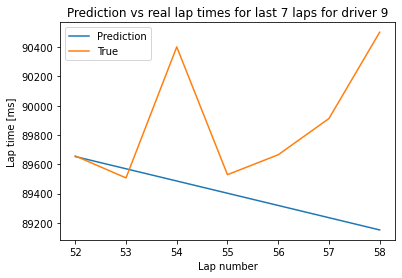

In [116]:
# Id for driver:
driverId = 9

# Extract the race data for the driver:
testDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] > numTrain]
trainingDataDriver = raceData[raceData["driverId"] == driverId][raceData["lap_number"] <= numTrain]

# Get the XTest and YTest:
lapNumbersDriverTest = np.array(testDataDriver["lap_number"])
lapTimesDriverTest = np.array(testDataDriver["lap_time"])

lapIsPitstopDriver = np.array(testDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(testDataDriver["pitstop_lagged"])
firstLap = np.array(testDataDriver["lap_number"] == 1).astype(int)

# Make the prediction:
predictionDriverOptimal = alphaOptimal[driverId - 1] + betaOptimal * lapNumbersDriverTest + deltaOptimal * lapIsPitstopDriver \
    + muOptimal * lapsLaggingPitStopDriver + phiOptimal * firstLap

# Plot predictions and true value
plt.plot(lapNumbersDriverTest, predictionDriverOptimal)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.title(f"Prediction vs real lap times for last {numTest} laps for driver {driverId}")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True"])



In [117]:
# Make predictions on the training data for all drivers:
optimalPrediction = XTrain @ optimalParameters

N = len(YTrain) # Number of samples
p = len(optimalParameters) # Number of parameters

# Calculate the variance sigma2 and std sigma:
sigma2Optimal = (trans(YTrain - optimalPrediction) @ np.linalg.inv(optimalCovMatrixAllDrivers) @ (YTrain - optimalPrediction)) /(N - p)
sigmaOptimal = np.sqrt(sigma2Optimal)
print(f"Sigma: {round(sigmaOptimal[0][0], 2)}")

Sigma: 1097.42


In [118]:
# Variance of parameters:
varParameters = sigma2Optimal * np.linalg.inv((trans(XTrain) @ XTrain))
for std in np.sqrt(np.diag(varParameters)):
    print(f"Std: {round(std, 2)}")

Std: 168.72
Std: 168.72
Std: 169.09
Std: 168.72
Std: 169.09
Std: 169.09
Std: 236.78
Std: 168.72
Std: 169.09
Std: 168.72
Std: 168.72
Std: 168.72
Std: 168.72
Std: 168.5
Std: 254.14
Std: 367.32
Std: 168.72
Std: 168.72
Std: 172.01
Std: 168.72
Std: 254.14
Std: 2.6
Std: 175.88
Std: 175.89
Std: 250.05


Predicted lap time: 89652.78 Prediction interval: +-3090.78 

Predicted lap time: 89569.34 Prediction interval: +-3136.74 

Predicted lap time: 89485.9 Prediction interval: +-3183.75 

Predicted lap time: 89402.46 Prediction interval: +-3231.79 

Predicted lap time: 89319.02 Prediction interval: +-3280.86 

Predicted lap time: 89235.58 Prediction interval: +-3330.93 

Predicted lap time: 89152.14 Prediction interval: +-3381.99 



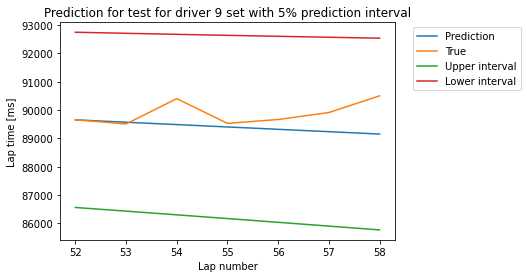

In [119]:
# Extract XTrain and YTrain for making prediction intervals on the test data:
lapNumbersTraining = trans(np.array([trainingDataDriver["lap_number"]]))
lapNumbersTest = trans(np.array([testDataDriver["lap_number"]]))

# Calculate prediction interval for the test data:
predictionIntervalDriverOptimal = []
predictedlaps = lapNumbersTraining
for lap in lapNumbersTest:
    predictedlaps = np.append(predictedlaps, lap)
    predictionIntervalDriverOptimal = np.append(predictionIntervalDriverOptimal, \
        t.ppf(1-0.025, N - p) * sigmaOptimal * np.sqrt(1 + trans(predictedlaps) * 1/(trans(lapNumbersTraining) @ lapNumbersTraining) @ predictedlaps))

# Plot predictions, true value and prediction interval:
plt.plot(lapNumbersDriverTest, predictionDriverOptimal)
plt.plot(lapNumbersDriverTest, lapTimesDriverTest)
plt.plot(lapNumbersDriverTest, predictionDriverOptimal - predictionIntervalDriverOptimal)
plt.plot(lapNumbersDriverTest, predictionDriverOptimal + predictionIntervalDriverOptimal)
plt.title(f"Prediction for test for driver {driverId} set with 5% prediction interval")
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"], bbox_to_anchor=(1.04,1), loc="upper left")

for lap in lapNumbersTest:
    print(f"Predicted lap time: {round(predictionDriverOptimal[lap - numTrain - 1][0], 2)} Prediction interval: +-{round(predictionIntervalDriverOptimal[lap - numTrain - 1][0], 2)} \n" )

Make prediction interval for whole data set:

In [120]:
# Id of the driver
driverId = 9

# Get the reace data for the driver
raceDataDriver = raceData[raceData["driverId"] == driverId]

lapNumbersDriver = trans(np.array(raceDataDriver["lap_number"]))
lapTimesDriver = trans(np.array(raceDataDriver["lap_time"]))

lapIsPitstopDriver = np.array(raceDataDriver["pitstop"]).astype(int)
lapsLaggingPitStopDriver = np.array(raceDataDriver["pitstop_lagged"])
firstLapDriver = np.array(raceDataDriver["lap_number"] == 1).astype(int)

optimalPredictionDriver = alphaOptimal[driverId - 1] + betaOptimal * lapNumbersDriver + deltaOptimal * lapIsPitstopDriver \
    + muOptimal * lapsLaggingPitStopDriver + phiOptimal * firstLapDriver

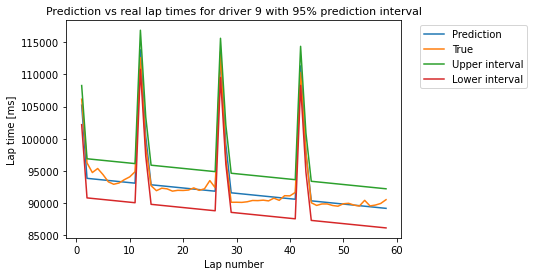

In [121]:
lapNumbersDriver = trans(np.array([raceDataDriver["lap_number"]]))
lapTimesDriver = trans(np.array([raceDataDriver["lap_time"]]))

# Make confidence intervals:
confidenceIntervalOptimal = t.ppf(1-0.025, N-p) * sigmaOptimal \
    * np.sqrt(1 + (trans(lapNumbersDriver) * 1/(trans(lapNumbersDriver) @ lapNumbersDriver) @ lapNumbersDriver))

# Plot predictions and true value
plt.plot(lapNumbersDriver, optimalPredictionDriver)
plt.plot(lapNumbersDriver, lapTimesDriver)
plt.plot(lapNumbersDriver, optimalPredictionDriver + confidenceIntervalOptimal[0])
plt.plot(lapNumbersDriver, optimalPredictionDriver - confidenceIntervalOptimal[0])
plt.title(f"Prediction vs real lap times for driver {driverId} with 95% prediction interval", size= 11)
plt.ylabel("Lap time [ms]")
plt.xlabel("Lap number")
plt.legend(["Prediction", "True", "Upper interval", "Lower interval"], bbox_to_anchor=(1.04,1), loc="upper left")